In [189]:
import numpy as np
import torch
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

Dataset

In [190]:
data = loadmat('emnist-letters.mat')

In [191]:
X_train = data['dataset']['train'][0][0]['images'][0][0].astype('float64')#[0:10000,:]
y_train = data['dataset']['train'][0][0]['labels'][0][0].ravel().astype('float64')#[0:10000]
y_train[y_train==26] = 0
X_test = data['dataset']['test'][0][0]['images'][0][0].astype('float64')#[0:1000,:]
y_test = data['dataset']['test'][0][0]['labels'][0][0].ravel().astype('float64')#[0:1000]
y_test[y_test==26] = 0
print(f'forma X_train {X_train.shape} forma y_train {y_train.shape}')
print(f'forma X_test {X_test.shape} forma y_test {y_test.shape}')

forma X_train (124800, 784) forma y_train (124800,)
forma X_test (20800, 784) forma y_test (20800,)


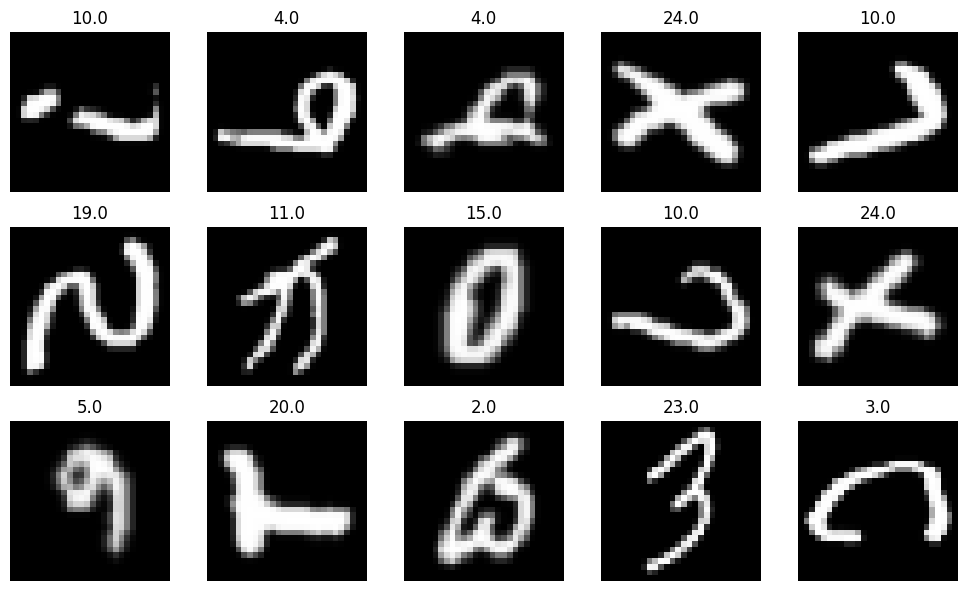

In [192]:
r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X_train)-1)
        img = X_train[ix]
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis("off")
        plt.title(y_train[ix])
plt.tight_layout()
plt.show()

Normalizacion

In [193]:
X_train /= 255.0
X_test /= 255.0

Funciones de activacion y perdida

In [194]:
# función de pérdida y derivada
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def sigmoid(x):
	return 1 / (1 + torch.exp(-x))

def cross_entropy(output, target):
    logits = output[torch.arange(len(output)), target]
    loss = - logits + torch.log(torch.sum(torch.exp(output), axis=-1))
    loss = loss.mean()
    return loss

Modelo

In [200]:
D_in, H1, H2, H3, D_out = 784, 300, 500, 700, 26

# Pesos capa oculta 1
w1 = torch.tensor(np.random.normal(loc=0.0,
          scale = np.sqrt(2/(D_in+H1)),
          size = (D_in, H1)), requires_grad=True, device="cuda", dtype=torch.float)
b1 = torch.zeros(H1, requires_grad=True, device="cuda", dtype=torch.float)

# Pesos capa oculta 2
w2 = torch.tensor(np.random.normal(loc=0.0,
          scale = np.sqrt(2/(D_in+H2)),
          size = (H1, H2)), requires_grad=True, device="cuda", dtype=torch.float)
b2 = torch.zeros(H2, requires_grad=True, device="cuda", dtype=torch.float)

# Pesos capa oculta 3
w3 = torch.tensor(np.random.normal(loc=0.0,
          scale = np.sqrt(2/(D_in+H3)),
          size = (H2, H3)), requires_grad=True, device="cuda", dtype=torch.float)
b3 = torch.zeros(H3, requires_grad=True, device="cuda", dtype=torch.float)

# Pesos capa de salida
w4 = torch.tensor(np.random.normal(loc=0.0,
          scale = np.sqrt(2/(D_out+H2)),
          size = (H3, D_out)), requires_grad=True, device="cuda", dtype=torch.float)
b4 = torch.zeros(D_out, requires_grad=True, device="cuda", dtype=torch.float)

# convertimos datos a tensores y copiamos en gpu
X_t = torch.from_numpy(X_train).float().cuda()
Y_t = torch.from_numpy(y_train).long().cuda()

Entrenamiento

Epoch 10/200 Loss 0.75203
Epoch 20/200 Loss 0.74158
Epoch 30/200 Loss 0.73230
Epoch 40/200 Loss 0.72169
Epoch 50/200 Loss 0.71371
Epoch 60/200 Loss 0.70517
Epoch 70/200 Loss 0.69588
Epoch 80/200 Loss 0.68558
Epoch 90/200 Loss 0.67685
Epoch 100/200 Loss 0.66853
Epoch 110/200 Loss 0.66024
Epoch 120/200 Loss 0.65272
Epoch 130/200 Loss 0.64588
Epoch 140/200 Loss 0.63857
Epoch 150/200 Loss 0.63185
Epoch 160/200 Loss 0.62612
Epoch 170/200 Loss 0.61989
Epoch 180/200 Loss 0.61395
Epoch 190/200 Loss 0.60855
Epoch 200/200 Loss 0.60284


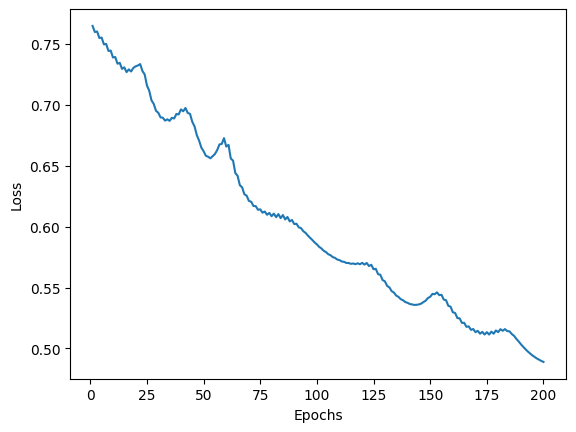

In [204]:
epochs = 200
lr = 0.9
l = []
for e in range(1, epochs+1):

    # forward
    z1 = X_t.mm(w1) + b1
    a1 = z1.clamp(min=0) # relu
    z2 = a1.mm(w2) + b2
    a2 = z2.clamp(min=0) # relu
    z3 = a2.mm(w3) + b3
    a3 = z3.clamp(min=0) # relu
    y_pred = a3.mm(w4) + b4

    # loss
    loss = cross_entropy(y_pred, Y_t)
    l.append(loss.item())

    # Backprop (calculamos todos los gradientes automáticamente)
    loss.backward()

    with torch.no_grad():
        # update pesos
        w1 -= lr * w1.grad
        b1 -= lr * b1.grad
        w2 -= lr * w2.grad
        b2 -= lr * b2.grad

        # ponemos a cero los gradientes para la siguiente iteración
        # (sino acumularíamos gradientes)
        w1.grad.zero_()
        w2.grad.zero_()
        b1.grad.zero_()
        b2.grad.zero_()

    if not e % 10:
        print(f"Epoch {e}/{epochs} Loss {np.mean(l):.5f}")

# Grafica descenso
plt.plot(range(1,epochs+1), l)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

Evaluacion

In [205]:
def evaluate(x):
    z1 = x.mm(w1) + b1
    a1 = z1.clamp(min=0) # relu
    z2 = a1.mm(w2) + b2
    a2 = z2.clamp(min=0) # relu
    z3 = a2.mm(w3) + b3
    a3 = z3.clamp(min=0) # relu
    y_pred = a3.mm(w4) + b4
    y_p = softmax(y_pred)
    return torch.argmax(y_p, axis=1)

Accuracy(Exactitud): 84.79326923076923 %
Precision(Precision): 0.8516948086426654
Recall(Sensibilidad): 0.8479326923076922
F1: 0.846880512464052


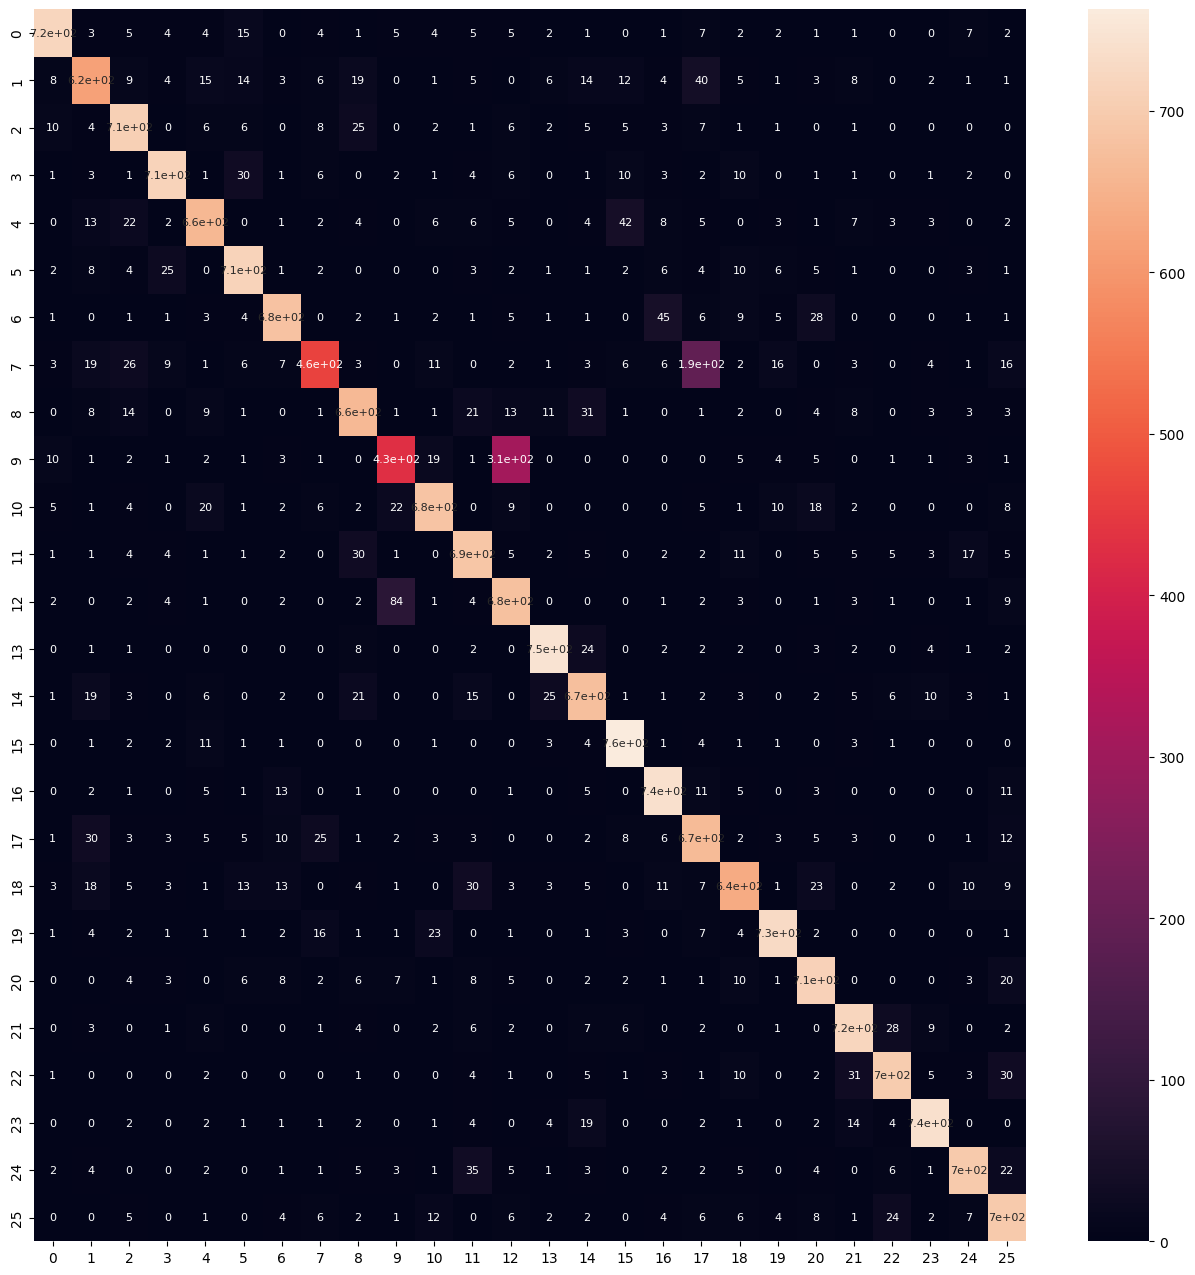

In [206]:
y_pred = evaluate(torch.from_numpy(X_test).float().cuda()).cpu().numpy()
print('Accuracy(Exactitud):',accuracy_score(y_test, y_pred)*100,'%')
print('Precision(Precision):',precision_score(y_test, y_pred, average='macro'))
print('Recall(Sensibilidad):',recall_score(y_test, y_pred, average='macro'))
print('F1:',f1_score(y_test, y_pred, average='macro'))
MC_train = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(16,16))
sns.heatmap(MC_train, annot = True, annot_kws = {'size': 8})
plt.show()

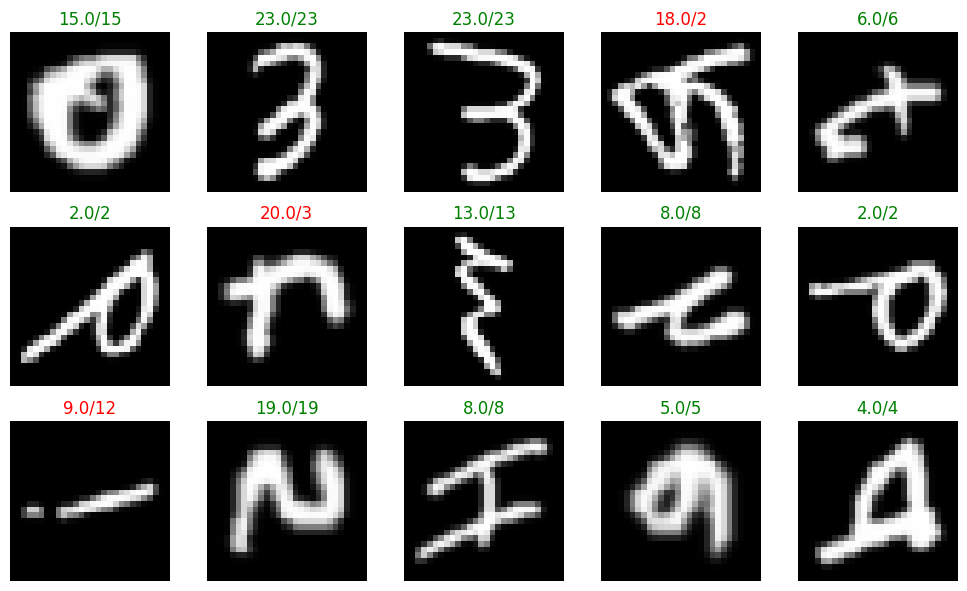

In [207]:
r, c = 3, 5
fig = plt.figure(figsize=(2*c, 2*r))
test_imgs, test_labs = [], []
for _r in range(r):
    for _c in range(c):
        plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(X_test)-1)
        img = X_test[ix]
        y_pred = evaluate(torch.tensor([img]).float().cuda())[0]
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis("off")
        plt.title(f"{y_test[ix]}/{y_pred}", color="green" if y_test[ix] == y_pred else "red")
plt.tight_layout()
plt.show()